In [1]:
import os
import numpy as np
import rasterio as rio

import sklearn
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from skimage.feature import canny
from scipy import ndimage as ndi 

In [2]:
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = np.nanmin(array), np.nanmax(array)
    return ((array - array_min)/(array_max - array_min))

def read_bands_and_stack(filename):
    b1 = rio.open(filename).read(1)
    b2 = rio.open(filename).read(2)
    b3 = rio.open(filename).read(3)
    ba = rio.open(filename).read(4)
    
    return np.dstack([b1,b2,b3,ba])

sites = ['OsoFlacoRiver','OceanoDunes','OsoFlacoLake','KanabDam', 'KanabRiver']

# find files
s1_tifs = [os.path.join("../composites/sentinel",x) for x in os.listdir("../composites/sentinel") if x.endswith(".tif")]
naip_tifs = [os.path.join("../composites/naip",x) for x in os.listdir("../composites/naip") if x.endswith(".tif")]
drone_tifs = [os.path.join("../composites/wgs84/", x) for x in os.listdir("../composites/wgs84") if x.endswith(".tif") if "vis" in x] 

# read the images
site_ims= {}

for site in sites[:]:
    print("-----"*10)
    print(site)
    print("-----"*10)
    s1_im_fn = [x for x in s1_tifs if site in x][0]
    naip_im_fn = [x for x in naip_tifs if site in x][0]
    drone_im_fn = [x for x in drone_tifs if site in x][0]
    
    # Read files 
    s1 = read_bands_and_stack(s1_im_fn)
    naip = read_bands_and_stack(naip_im_fn)
    drone = mpimg.imread(drone_im_fn)
    
    im_dict = dict(zip(['drone','s1','naip'],[drone,s1,naip]))

#     im_dict = dict(zip(['drone','s1','naip'],[mpimg.imread(x) for x in [drone_im_fn, s1_im_fn, naip_im_fn]]))
    
    im_dict_masked = {}
    for k,v in im_dict.items():
        mask_arr = v[:,:,3].copy().astype(float)
        mask_arr[mask_arr==0] = np.nan
        bandarrs = [v[:,:,x] * mask_arr for x in range(0,3)]
        
        m_arr = np.dstack([(x) for x in bandarrs])
        im_dict_masked[k] = m_arr
        
    site_ims[site] = im_dict_masked

--------------------------------------------------
OsoFlacoRiver
--------------------------------------------------
--------------------------------------------------
OceanoDunes
--------------------------------------------------
--------------------------------------------------
OsoFlacoLake
--------------------------------------------------
--------------------------------------------------
KanabDam
--------------------------------------------------
--------------------------------------------------
KanabRiver
--------------------------------------------------


# SPECTRAL THRESHOLD CLASSIFICATION 

### Compute spectral indices: 

VARI = $ \frac{ρ_{green} - ρ_{red}}{ρ_{green} + ρ_{red} + ρ_{blue}} $ 

NDVI = $ \frac{ρ_{NIR} - ρ_{red}}{ρ_{NIR} + ρ_{red}} $ 

Sentinel NIR Band == band 8 <br>
Sentinel red Band == band 4

In [3]:
def vari(image_3_channel):
    vari = (image_3_channel[:,:,1] - image_3_channel[:,:,0]) / (image_3_channel[:,:,1] + image_3_channel[:,:,0] + + image_3_channel[:,:,2])
    return vari
    
    

OsoFlacoRiver


/var/folders/zd/rjxfh38941s3dn35jv9cdgmw0000gn/T/ipykernel_3174/3398548043.py:2: RuntimeWarning: invalid value encountered in true_divide
  vari = (image_3_channel[:,:,1] - image_3_channel[:,:,0]) / (image_3_channel[:,:,1] + image_3_channel[:,:,0] + + image_3_channel[:,:,2])


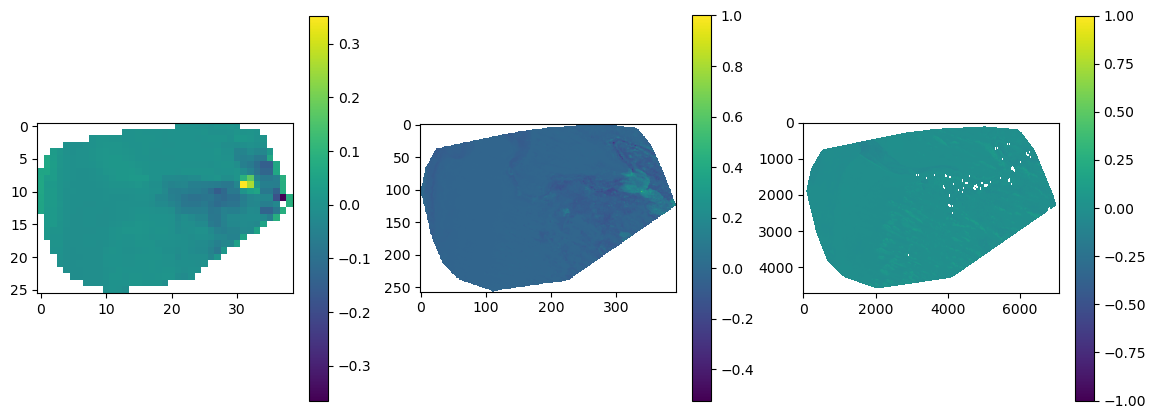

OceanoDunes


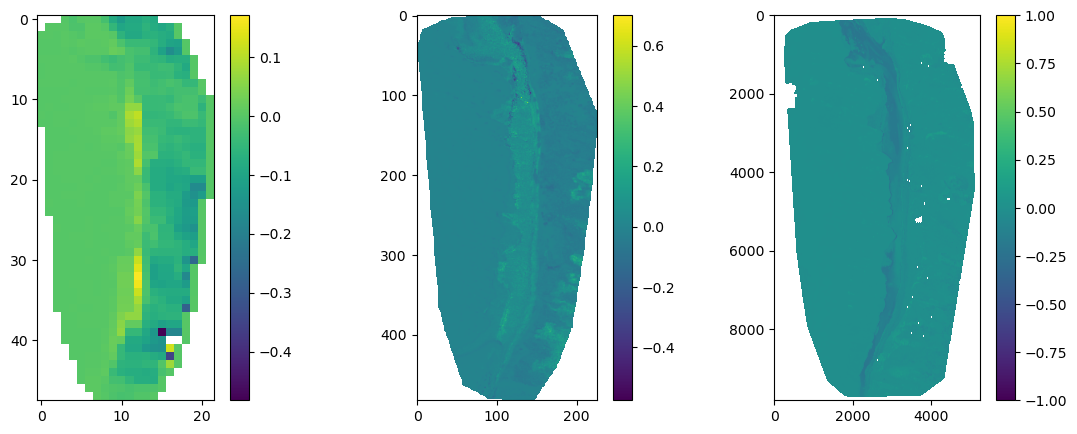

OsoFlacoLake


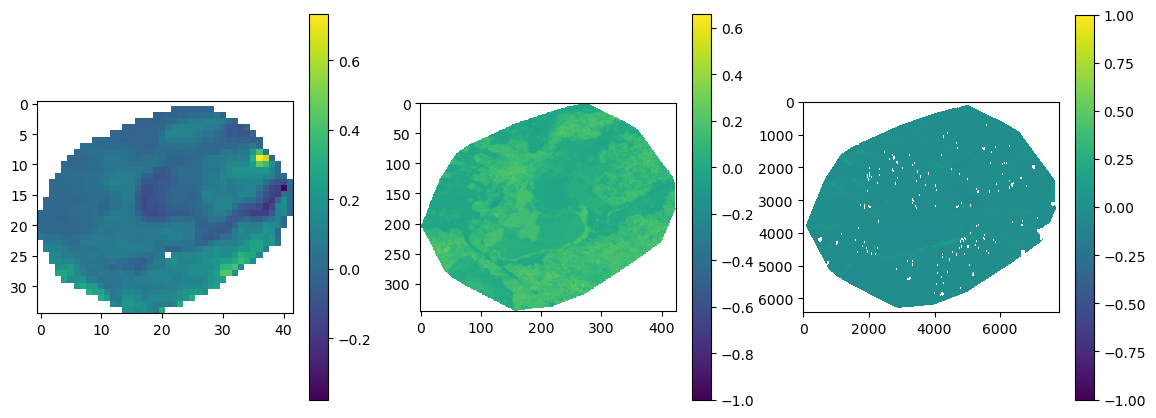

KanabDam


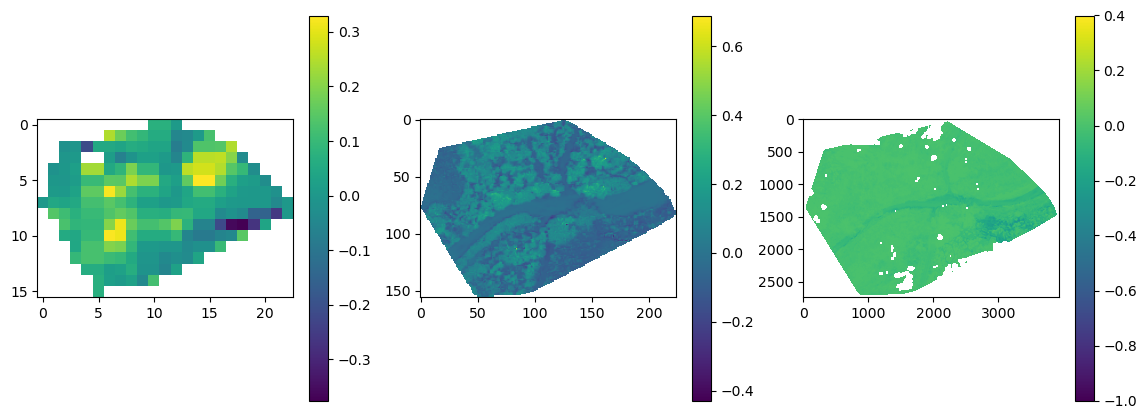

KanabRiver


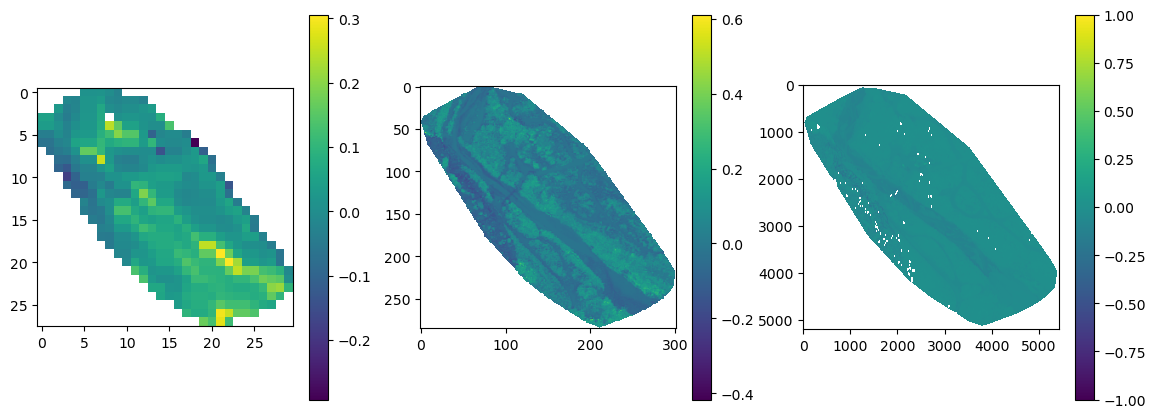

In [4]:
for k,v in site_ims.items():
    print(k)
    drone_vari = vari(v['drone'])
    naip_vari = vari(v['naip'])
    s1_vari = vari(v['s1'])
    
    plt.figure(figsize=(14,5))
    plt.subplot(131)
    plt.imshow(s1_vari); plt.colorbar();
        
    plt.subplot(132)
    plt.imshow(naip_vari); plt.colorbar();
    
    plt.subplot(133)
    plt.imshow(drone_vari); plt.colorbar();
    
    plt.show()

In [5]:
# def classify_water(im):
#     e1 = ndi.binary_fill_holes(canny(im[:,:,0], sigma = 1))
#     e2 = ndi.binary_fill_holes(canny(im[:,:,1], sigma = 1))
#     e3 = ndi.binary_fill_holes(canny(im[:,:,2], sigma = 1))
    
#     probs = e1.astype(int)+e2.astype(int)+e3.astype(int)
    
#     return normalize(probs)




In [6]:
# plt.subplot(111)
# plt.imshow(classify_water(site_ims['KanabDam']['drone'])); plt.colorbar()

In [7]:
# for k,v in site_ims.items():
#     print(k)
#     drone_class = classify_water(v['drone'])
#     naip_class = classify_water(v['naip'])
#     s1_class = classify_water(v['s1'])
    
#     plt.figure(figsize=(14,5))
#     plt.subplot(131)
#     plt.imshow(s1_class); plt.colorbar();
        
#     plt.subplot(132)
#     plt.imshow(naip_class); plt.colorbar();
    
#     plt.subplot(133)
#     plt.imshow(drone_class); plt.colorbar();
    
#     plt.show()